In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import (Linear, Sequential, MSELoss)
import matplotlib.pyplot as plt
import networkx as nx
from torchmtl import MTLModel
from torchmtl.wrapping_layers import Concat
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

### Generate the data set
Generate datasets $(x,y_1)$ and $(x,y_2)$ for two linear regression tasks <br>

$ y_1=w_1x+b_1+\sigma_1 $ <br>
$ y_2=w_2x+b_2+\sigma_2 $ <br>


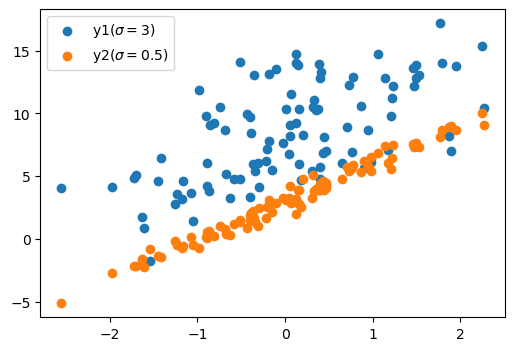

In [3]:
# Parameters
sample_num = 100
nb_features = 1024
input_size = 1
hidden_size = 2  # total number of output
output1_size = 1  # first output
output2_size = 1  # second output
sigma1, sigma2 = 3.0, 0.5  # ground truth

# Generate the data set
def gen_data(sample_num, sigma1, sigma2):
    X = np.random.randn(sample_num, input_size)
    w1 = 2.
    b1 = 8.
    Y1 = X.dot(w1) + b1 + sigma1 * np.random.randn(sample_num, output1_size)
    w2 = 3.
    b2 = 3.
    Y2 = X.dot(w2) + b2 + sigma2 * np.random.randn(sample_num, output2_size)
    return X, Y1, Y2

def shuffle_data(X, Y1, Y2):
    s = np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s], Y1[s], Y2[s]

# Generate and convert data into torch from numpy array
X, Y1, Y2 = gen_data(sample_num, sigma1, sigma2)
X = X.astype('float32')
Y1 = Y1.astype('float32')
Y2 = Y2.astype('float32')

plt.figure(figsize=(6, 4))
plt.scatter(X, Y1)
plt.scatter(X, Y2)
plt.legend([r'y1($\sigma=3$)', r'y2($\sigma=0.5$)'], loc=0)
plt.show()

### Create Multi-task learning model for linear regression

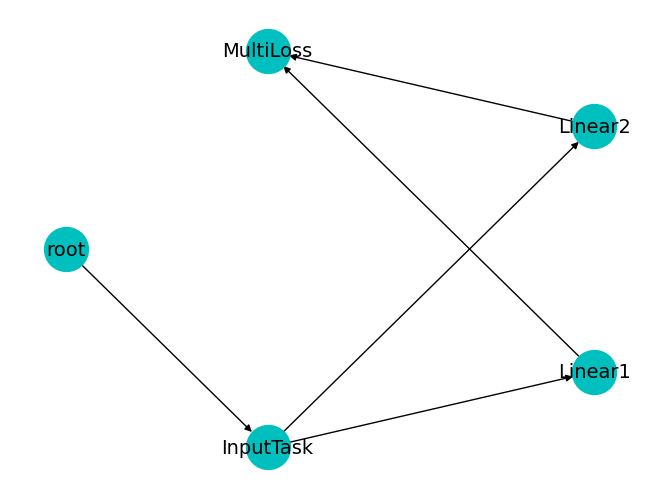

In [4]:
# Define a loss function that returns the log vars
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, num_tasks):
        super(MultiTaskLossWrapper, self).__init__()
        self.num_tasks = num_tasks
        self.log_vars = nn.Parameter(torch.zeros((num_tasks)))

    def forward(self, *X):
        # Return the log vars so precision can be computed
        # in the training loop. Also return the predictions.
        return self.log_vars, X


# Define MTL tasks
tasks = [
        {
            'name': "InputTask",
            'layers': Sequential(*[nn.Linear(input_size, hidden_size), nn.ReLU()]),
            # No anchor_layer means this layer receives input directly
        },    
        {
            'name': "Linear1",
            'layers': nn.Linear(hidden_size, output1_size),
            'anchor_layer': "InputTask"
        },    
        {
            'name': "Linear2",
            'layers': nn.Linear(hidden_size, output2_size),
            'anchor_layer': "InputTask"
        },
        {
            'name': "MultiLoss",
            'layers': MultiTaskLossWrapper(num_tasks=2),
            'anchor_layer': ['Linear1', 'Linear2']
        }
    ]

model = MTLModel(tasks, output_tasks=['MultiLoss'])

# Visualize MTL architecture
pos = nx.shell_layout(model.g)
nx.draw(model.g, pos, font_size=14, node_color="c", node_size=1000, with_labels=True)
plt.show()

### Training

In [5]:
# Define an optimizer
optimizer = optim.Adam(model.parameters())

nb_epoch = 2000
batch_size = 20

losses = []
params = []
for i in range(nb_epoch):

    epoch_loss = 0
    epoch_params = []
    X, Y1, Y2 = shuffle_data(X, Y1, Y2)
    
    for j in range(sample_num // batch_size):
        optimizer.zero_grad()

        X_ = torch.from_numpy(X[(j * batch_size):((j + 1) * batch_size)])
        target1 = torch.from_numpy(Y1[(j * batch_size):((j + 1) * batch_size)])
        target2 = torch.from_numpy(Y2[(j * batch_size):((j + 1) * batch_size)])
        y = [target1, target2]
        
        multi_loss_out, _, _ = model(X_)
        log_vars = multi_loss_out[0][0]
        y_hat = multi_loss_out[0][1]
        
        epoch_params = log_vars.detach().numpy()

        loss = 0
        for i in range(len(y)):
            precision = torch.exp(-log_vars[i])
            diff = (y_hat[i] - y[i])**2.
            loss += torch.sum(precision * diff + log_vars[i], -1)  
        loss = torch.mean(loss)
        
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss * batch_size / sample_num)
    params.append(epoch_params.copy())

NameError: name 'N' is not defined

### Plot loss and sigma during training

[3.0401804447174072, 0.5398078560829163]


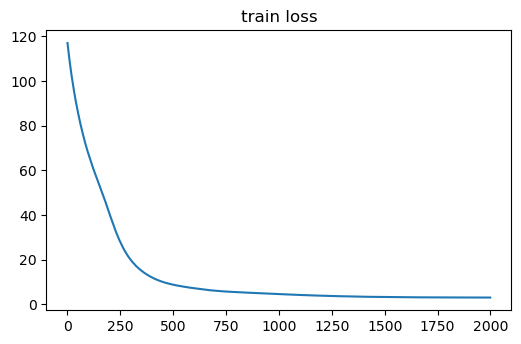

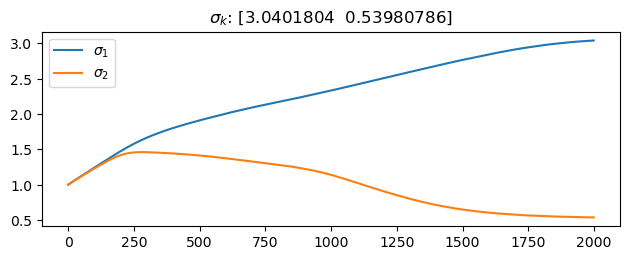

In [34]:

# Found standard deviations
std_1 = torch.exp(log_vars[0])**0.5
std_2 = torch.exp(log_vars[1])**0.5
print([std_1.item(), std_2.item()])

# Visualize the overall loss 
plt.figure(figsize=(6, 8))
plt.subplot(211)
plt.title('train loss')
plt.plot(losses)
plt.show()

# Visualize the overall sigmas
sigmas = np.sqrt(np.exp(params))

plt.subplot(212)
plt.title(r'$\sigma_k$: ' + f'{sigmas[-1]}')
plt.plot(sigmas[:, 0])
plt.plot(sigmas[:, 1])
plt.legend([r'$\sigma_1$', r'$\sigma_2$'])

plt.tight_layout()
plt.show()
